In [3]:
import numpy as np
import scipy.signal
import soundfile as sf
import matplotlib.pyplot as plt
from scipy.signal import butter, lfilter


Matplotlib is building the font cache; this may take a moment.


In [14]:
# Load audio file
def load_audio(file_path):
    y, sr = sf.read(file_path)
    if len(y.shape) > 1:  # Convert to mono if stereo
        y = np.mean(y, axis=1)
    return y, sr

# Plot spectrogram
def plot_spectrogram(y, sr, title="Spectrogram"):
    plt.figure(figsize=(10, 4))
    f, t, Sxx = scipy.signal.spectrogram(y, sr)
    plt.pcolormesh(t, f, 10 * np.log10(Sxx + 1e-10), shading='gouraud')
    plt.colorbar(label='dB')
    plt.title(title)
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [s]')
    plt.show()

# Apply adaptive EQ based on frequency difference
def adaptive_eq(y, sr, spectrum_diff, freqs):
    eq_adjusted = np.copy(y)
    
    # Ensure gain_factor matches the length of the frequency spectrum
    gain_factor = np.interp(freqs, freqs, [0.8, 1.2])
    
    # Apply gain factor to the frequency domain representation of the audio
    y_fft = np.fft.rfft(y)
    y_fft *= gain_factor
    eq_adjusted = np.fft.irfft(y_fft, n=len(y))
    
    return eq_adjusted

# Apply low-pass filter
def apply_filter(y, sr, cutoff=1000, filter_type='low'):
    b, a = butter(4, cutoff / (sr / 2), btype=filter_type)
    return lfilter(b, a, y)

# Process audio for matching
def process_audio(source_path, target_path, output_path):
    source_audio, sr_source = load_audio(source_path)
    target_audio, sr_target = load_audio(target_path)

    assert sr_source == sr_target, "Sample rates do not match!"
    
    # Plot spectrograms
    plot_spectrogram(source_audio, sr_source, title="Source: Elastic Lead")
    plot_spectrogram(target_audio, sr_target, title="Target: Electric Buzz")
    
    # Compute frequency spectrum difference
    source_spectrum = np.abs(np.fft.rfft(source_audio))
    target_spectrum = np.abs(np.fft.rfft(target_audio))
    freqs = np.fft.rfftfreq(len(source_audio), d=1/sr_source)
    spectrum_diff = target_spectrum - source_spectrum
    
    # Apply adaptive EQ
    processed_audio = adaptive_eq(source_audio, sr_source, spectrum_diff, freqs)
    
    # Apply additional filtering
    processed_audio = apply_filter(processed_audio, sr_source, cutoff=5000, filter_type='low')
    
    # Save processed audio
    sf.write(output_path, processed_audio, sr_source)
    return output_path



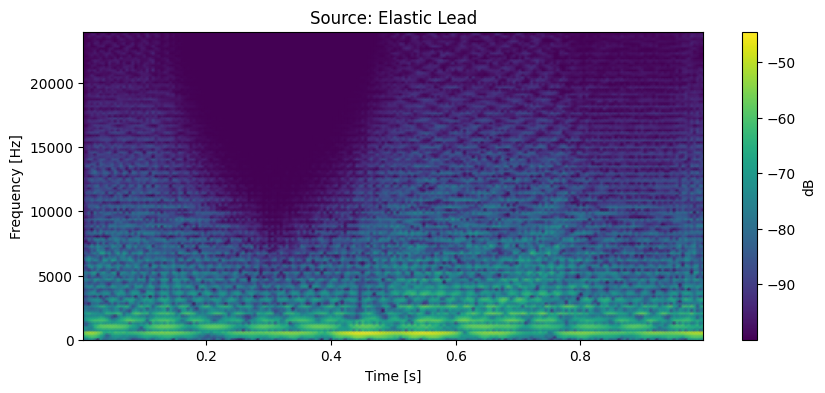

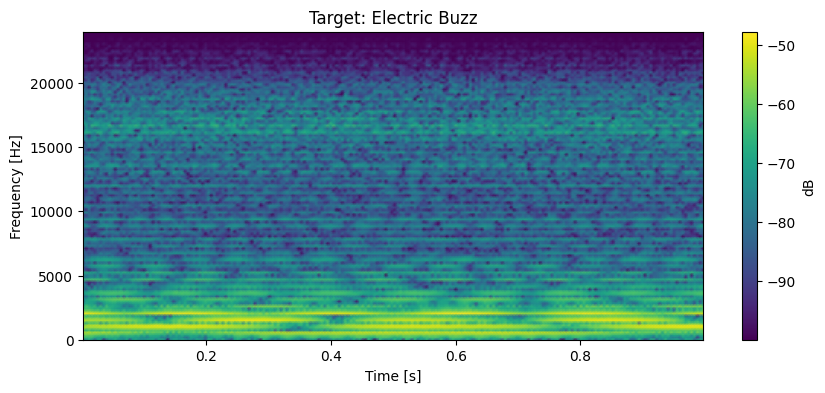

ValueError: fp and xp are not of the same length.

In [16]:
# Define file paths
source_file_path = "Elastic_Lead.wav"
target_file_path = "Electric_Buzz.wav"
output_processed_audio = "Processed_Electric_Buzz.wav"

# Run the processing function
process_audio(source_file_path, target_file_path, output_processed_audio)